<a href="https://colab.research.google.com/github/ykitaguchi77/GO_AI_project/blob/main/Hertel_YOLOv5_MobileNetv3_pipeline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Hertel estimation YOLOv5-MobileNetv3 pipeline**

Train YOLOv5

```
Olympia dataset
Dlibで目が2つ検出されるものを抜き出す
YOLOv5を用いて左右とバウンディングボックスを認識させる
抜き出した画像についてMobileNetV3で回帰（5-fold ensemble）を行う
スマホに実装
```

Output as CoreML

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time
import os
import shutil
import copy
import pandas as pd
import csv
from random import randint
from time import sleep
import numpy as np
import sys
import torch
from tqdm import tqdm
import cv2
from google.colab.patches import cv2_imshow


import glob
import random
from PIL import Image
%matplotlib inline

# #サポートパッチのインポート
# from google.colab.patches import cv2_imshow
# import cv2

plt.ion()   # interactive mode
!nvidia-smi
print(torch.cuda.is_available())


Wed Nov  8 17:55:15 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   39C    P8     9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
#残り時間確認
!cat /proc/uptime | awk '{printf("残り時間 : %.2f", 12-$1/60/60)}'


残り時間 : 11.89

#Google colabをマウント

In [2]:
'''
・dlibを用いて目を切り抜く
・横幅を2倍、縦幅を上に1倍追加/下に0.5倍追加した両眼の画像が含まれるように切り取る（目の全幅、眉毛が含まれるように）
'''

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
#親フォルダ
parent_dir = '/content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5'

#元画像フォルダ
dataset_dir = '/content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset'

#元画像をコピー
orig_dir = f"{parent_dir}/dataset_orig"

#切りぬいた画像を保存するフォルダ
out_dir = f"{parent_dir}/dataset_uni"

#トレーニングされたYOLOv5で切り抜いた画像を保存するフォルダ
cropped_dir = f"{parent_dir}/dataset_yolo_cropped"

#CSVファイルのフォルダ
csv_hertel_path = "/content/drive/MyDrive/Deep_learning/Olympia_dataset/Hertel.csv"
csv_coordinate_path = f"{parent_dir}/coordinate_uni_for_YOLO5.csv"
csv_integrated_path = f"{parent_dir}/integrated_uni_for_YOLO5.csv"

In [ ]:
"""
###################################
# Refresh folder (内容が削除されるので注意！！) #
###################################
"""

# parent_dirがあれば削除する
if os.path.exists(parent_dir):
    shutil.rmtree(parent_dir)

# 新しくparent_dirを作成する
os.makedirs(parent_dir)

# orig_dir, out_dirを新規に作成する
os.makedirs(orig_dir)
os.makedirs(out_dir)
os.makedirs(cropped_dir)

# orig_dirにdataset_dir直下のファイルをすべてコピーする
file_list = os.listdir(dataset_dir)
for filename in tqdm(file_list, desc="Copying files", unit="file"):
    src_path = os.path.join(dataset_dir, filename)
    dst_path = os.path.join(orig_dir, filename)
    shutil.copy(src_path, dst_path)

print("処理が完了しました。")


Copying files: 100%|██████████| 1016/1016 [00:12<00:00, 83.69file/s]

処理が完了しました。


#**HaarCascadeを用いて目を検出**

In [ ]:
# カスケードファイルのパス
eye_cascade_path = '/content/drive/My Drive/Deep_learning/haarcascade_eye.xml'

# カスケード分類器の特徴量取得
eye_cascade = cv2.CascadeClassifier(eye_cascade_path)

#**目が2つ以上検出されたものを抜き出す**

dlibで検出されたものから、上下左右に0.1倍ずつ拡大した範囲を抜き出している

In [ ]:
with open(csv_coordinate_path, 'w', newline='') as f:
        #fieldnames = ['Number', 'Folder', 'FileName']
        writer = csv.writer(f)
        writer.writerow(['id','img_path', 'side R/L', 'ex', 'ey', 'ew', 'eh'])  #header

        files = os.listdir(orig_dir)

        k=0
        for file in files:  #フォルダ数の分だけ
              file_path = f"{orig_dir}/{file}"
              id = os.path.splitext(os.path.basename(file_path))[0]

              img = cv2.imread(file_path)
              img2 = img.copy()

              # 画像グレースケール化
              grayscale_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

              #300pix以上のもので目に見えるものを抽出
              eye_list = eye_cascade.detectMultiScale(grayscale_img, minSize=(300, 300))

              # 眼検出判定
              if len(eye_list) >= 1:
                  print('目が' + str(len(eye_list)) +'個検出されました')
              else:
                  print("eye detection error")

              #画像の切り抜きと保存（2個以上検出の時に限る）
              if len(eye_list) >= 2:
                  for (ex, ey, ew, eh) in eye_list:
                      print(f"img_width: {img2.shape[1]}")
                      print("[ex,ey] = %d,%d [ew,eh] = %d,%d" %(ex, ey, ew, eh))
                      cv2.rectangle(img2, (ex, ey), (ex + ew, ey + eh), (0, 255, 0), 2)
                      img_cropped = img[int(ey-0.1*eh): int(ey+1.1*eh), int(ex-0.1*ew): int(ex+1.1*ew)] #本来の切り抜きより幅の0.1倍ずつ水増しする
                      #img_cropped = img[int(ey): int(ey+eh), int(ex): int(ex+ew)]


                      if ex+eh*0.5 <= img2.shape[1]/2:
                          side = "R" #横幅の半分より左にあるのは右眼
                      else:
                          side = "L" #横幅の半分よりより右にあるのは左眼

                      print(f"side: {side}")
                      print("")

                      # Check if coordinates are within the image bounds
                      ey_start = max(int(ey - 0.1 * eh), 0)
                      ey_end = min(int(ey + 1.1 * eh), img.shape[0])
                      ex_start = max(int(ex - 0.1 * ew), 0)
                      ex_end = min(int(ex + 1.1 * ew), img.shape[1])

                      # Ensure we have a valid crop area
                      if ex_start < ex_end and ey_start < ey_end:
                          img_cropped = img[ey_start: ey_end, ex_start: ex_end]

                          # Now do the checks for the right/left side, write image and row
                          # ...

                          cv2.imwrite(f"{out_dir}/{id}_{side}.png", img_cropped)

                      #対応表の作成
                      writer.writerow([id, file_path, side, ex-round(ew*0.1), ey-round(eh*0.1), round(ew*1.2), round(eh*1.2)])

                      #cv2_imshow(img_cropped)
                  else:
                      pass


##**ここで、目以外が誤検出されているものを手動で抜き出して削除する**

```
coordinate_uni_for_YOLO5.csvから、削除して画像のパスが存在しなくなっている行を削除する

```

In [ ]:
import os
import pandas as pd

# DataFrameを読み込む
coordinates_df = pd.read_csv(csv_coordinate_path)

# 存在しない画像パスをチェックし、そのリストを保持する
nonexistent_paths = coordinates_df[~coordinates_df['img_path'].apply(os.path.exists)]

# 存在しない画像パスを表示
print("Nonexistent image paths:")
print(nonexistent_paths['img_path'])

# # 存在しない画像パスの行を削除
# coordinates_df = coordinates_df[coordinates_df['img_path'].apply(os.path.exists)]

# # 更新されたDataFrameを保存する
# coordinates_df.to_csv('coordinate_uni_for_YOLO5.csv', index=False)


Nonexistent image paths:
Series([], Name: img_path, dtype: object)


##**Dataframeの整理**

・ hertel_dfを参照して、coordinates_dfにヘルテル値を記入する

・idが"16_R, 16_L"という形式になるようにデータフレームを整理する

In [ ]:
import pandas as pd

# Assuming csv_coordinate_path and csv_hertel_path are defined paths to the CSV files
coordinates_df = pd.read_csv(csv_coordinate_path)
hertel_df = pd.read_csv(csv_hertel_path)

coordinates_df['Hertel'] = None

def get_hertel_value(row, hertel_df):
    id = row['id']
    side = row['side R/L']
    hertel_value = hertel_df.loc[hertel_df['number'] == id, side].values
    return hertel_value[0] if len(hertel_value) > 0 else None

# Use .copy() to ensure that you're working with a copy and not a view
coordinates_df['Hertel'] = coordinates_df.apply(lambda row: get_hertel_value(row, hertel_df), axis=1)

id_counts = coordinates_df.groupby('id')['side R/L'].value_counts().unstack()
valid_ids = id_counts[(id_counts['R'] == 1) & (id_counts['L'] == 1)].index

# Filter the DataFrame to only include these ids
# Use .copy() to avoid SettingWithCopyWarning when modifying this DataFrame later
coordinates_filtered_df = coordinates_df[coordinates_df['id'].isin(valid_ids)].copy()
coordinates_filtered_df.reset_index(drop=True, inplace=True)

coordinates_filtered_df.to_csv(csv_integrated_path, index=False)
coordinates_filtered_df.head()

,id,img_path,side R/L,ex,ey,ew,eh,Hertel
0,19,/content/drive/MyDrive/Deep_learning/Olympia_d...,R,107,557,835,835,15.0
1,19,/content/drive/MyDrive/Deep_learning/Olympia_d...,L,1513,547,850,850,16.0
2,20,/content/drive/MyDrive/Deep_learning/Olympia_d...,R,74,483,942,942,18.0
3,20,/content/drive/MyDrive/Deep_learning/Olympia_d...,L,1488,486,978,978,18.0
4,21,/content/drive/MyDrive/Deep_learning/Olympia_d...,R,147,555,868,868,19.0


In [ ]:
'''
画像パスの抽出（RLともに揃っているもの）
'''
coordinates_filtered_df = coordinates_filtered_df.drop_duplicates(subset='id', keep='first')
img_path_list = coordinates_filtered_df['img_path'].tolist()


'''
画像の分割 train:valid = 8:2
'''
random.seed(42)  # For reproducibility
random.shuffle(img_path_list)

split_index = int(0.8 * len(img_path_list))
train_img_paths = img_path_list[:split_index]
valid_img_paths = img_path_list[split_index:]

if os.path.exists(out_dir):
    shutil.rmtree(out_dir)
os.makedirs(out_dir)

'''
フォルダの作成
'''
folders = ['train/images', 'train/labels', 'valid/images', 'valid/labels']
for folder in folders:
    os.makedirs(os.path.join(out_dir, folder))


'''
画像のコピー
'''
# Define paths for images directories
train_images_dir = os.path.join(out_dir, 'train/images')
valid_images_dir = os.path.join(out_dir, 'valid/images')

# Copy training images
for img_path in tqdm(train_img_paths, desc='Copying train images'):
    shutil.copy(img_path, train_images_dir)

# Copy validation images
for img_path in tqdm(valid_img_paths, desc='Copying valid images'):
    shutil.copy(img_path, valid_images_dir)

Copying valid images: 100%|██████████| 190/190 [00:02<00:00, 72.86it/s]


In [ ]:
import os
import pandas as pd
from PIL import Image

def get_image_dimensions(image_path):
    with Image.open(image_path) as img:
        return img.width, img.height

def convert_to_yolo_format(ex, ey, ew, eh, img_width, img_height):
    cx = (ex + (ew / 2)) / img_width
    cy = (ey + (eh / 2)) / img_height
    w = ew / img_width
    h = eh / img_height
    return cx, cy, w, h

def create_label_files(image_dir, label_dir, df):
    image_files = os.listdir(image_dir)
    for image_file in tqdm(image_files, desc="Processing images"):
        image_path = os.path.join(image_dir, image_file)
        img_width, img_height = get_image_dimensions(image_path)

        base_name = os.path.splitext(image_file)[0]
        matched_rows = df[df['id'] == int(base_name)]

        if matched_rows.empty:
            raise ValueError(f"No matching id found for image {image_file}")

        label_file_path = os.path.join(label_dir, f"{base_name}.txt")
        with open(label_file_path, 'w') as label_file:
            for _, row in matched_rows.iterrows():
                ex = row['ex']
                ey = row['ey']
                ew = row['ew']
                eh = row['eh']
                cx, cy, w, h = convert_to_yolo_format(ex, ey, ew, eh, img_width, img_height)
                side = 0 if row['side R/L'] == 'R' else 1
                label_file.write(f" {side} {cx} {cy} {w} {h}\n")
                #label_file.write(f"{ex} {ey} {ew} {eh} {side}\n")

# CSVファイルの読み込み
csv_integrated_df = pd.read_csv(csv_integrated_path)

# trainとvalidのディレクトリパス
train_images_dir = os.path.join(out_dir, "train/images")
train_labels_dir = os.path.join(out_dir, "train/labels")
valid_images_dir = os.path.join(out_dir, "valid/images")
valid_labels_dir = os.path.join(out_dir, "valid/labels")

# trainディレクトリでラベルファイルを生成
create_label_files(train_images_dir, train_labels_dir, csv_integrated_df)

# validディレクトリでラベルファイルを生成
create_label_files(valid_images_dir, valid_labels_dir, csv_integrated_df)


Processing images: 100%|██████████| 190/190 [01:49<00:00,  1.73it/s]


In [ ]:
##############################
## バウンディングボックスのサンプル描画 ##
## (これは実行しなくて良い)            ##
##############################

import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image

# バウンディングボックスを描画する関数
def get_image_dimensions(image_path):
    with Image.open(image_path) as img:
        return img.width, img.height

def draw_bounding_boxes(image_path, bboxes):
    with Image.open(image_path) as img:
        img_width, img_height = img.size
        fig, ax = plt.subplots(1)
        ax.imshow(img)
        for bbox in bboxes:
            cx, cy, bw, bh, class_id = bbox
            x = (cx - bw / 2) * img_width
            y = (cy - bh / 2) * img_height
            width = bw * img_width
            height = bh * img_height
            rect = patches.Rectangle((x, y), width, height, linewidth=2, edgecolor='r', facecolor='none')
            ax.add_patch(rect)
        plt.show()

# ラベルファイルからバウンディングボックスのリストを取得する関数
def get_bboxes_from_label_file(label_path, img_width, img_height):
    bboxes = []
    with open(label_path, 'r') as file:
        for line in file:
            cx, cy, bw, bh, class_id = map(float, line.split())
            bboxes.append((cx, cy, bw, bh, class_id))
    return bboxes

# 画像パスとラベルファイルパス
image_path = "/content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_uni/valid/images/10.JPG"
label_path = "/content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_uni/valid/labels/10.txt"

# 画像のサイズを取得
img_width, img_height = get_image_dimensions(image_path)

# ラベルファイルからバウンディングボックスのリストを取得
bboxes = get_bboxes_from_label_file(label_path, img_width, img_height)


# バウンディングボックスを描画
print(f"img_width: {img_width}, img_height: {img_height}")
print(f"bboxes: {bboxes}")
draw_bounding_boxes(image_path, bboxes)


In [ ]:
%cd $out_dir

/content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_uni


In [ ]:
%%writefile dataset.yaml
train: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_uni/train/images
val: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_uni/valid/images

nc: 2
names: ['right', 'left']

Overwriting dataset.yaml


#**Setup YOLOv5**

In [ ]:
# # YOLOv5_iFish --> train_batchの精度が低いので一旦却下とした
# %cd $out_dir
# !git clone https://github.com/ykitaguchi77/yolov5-iFish.git #iFish augmentationを実装したバージョン
# %cd yolov5-iFish
# %pip install -qr requirements.txt

# import torch
# import utils
# display = utils.notebook_init()

YOLOv5 🚀 4d3e758 Python-3.10.12 torch-2.1.0+cu118 CUDA:0 (Tesla T4, 15102MiB)


Setup complete ✅ (8 CPUs, 51.0 GB RAM, 28.2/166.8 GB disk)


In [ ]:
# YOLOv5
%cd $out_dir
!git clone https://github.com/ultralytics/yolov5
%cd yolov5
%pip install -qr requirements.txt

import torch
import utils
display = utils.notebook_init()

YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CUDA:0 (Tesla T4, 15102MiB)


Setup complete ✅ (8 CPUs, 51.0 GB RAM, 28.2/166.8 GB disk)


#**Train YOLOv5**

In [ ]:
# Train
!python train.py --img 640 --batch 16 --epochs 300 --data $out_dir/dataset.yaml --weights yolov5n.pt

In [ ]:
# 途中から
!python train.py --img 640 --batch 16 --epochs 300 --data $out_dir/data.yaml --resume $out_dir/yolov5/runs/train/exp/weights/last.pt

In [ ]:
# best.pyをrenameしてgdriveに移動しておく
orig_pt = f"{out_dir}/yolov5/runs/train/exp/weights/best.pt"
dst_pt = f"{out_dir}/eyecrop-yolov5n-167epoch.pt"
shutil.copy(orig_pt, dst_pt)

'/content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_uni/eyecrop-yolov5n-167epoch.pt'

#**Inference original dataset**

In [4]:
%cd $out_dir/yolov5

import torch
import utils
%pip install -qr requirements.txt
display = utils.notebook_init()

YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CUDA:0 (Tesla T4, 15102MiB)


Setup complete ✅ (8 CPUs, 51.0 GB RAM, 28.1/166.8 GB disk)


In [20]:
# YOLOv5
#weight = "/content/drive/MyDrive/Deep_learning/GO_extended_dataset/super_extend_for_YOLO_training/yolov5-iFish/runs/train/exp2/weights/best.pt"
#weight = "/content/drive/MyDrive/Deep_learning/GO_extended_dataset/super_extend_for_YOLO_training/yolov5n-iFish_120epoch.pt"
weight = f"{out_dir}/dataset_uni/eyecrop-yolov5n-iFish_169epoch.pt"
weight = "/content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_uni/eyecrop-yolov5n-167epoch.pt"

# もともとのデータセット
orig_dir = orig_dir #元画像
cropped_dir = cropped_dir #YOLOv5で切り抜いた画像用

if os.path.exists(cropped_dir):
    shutil.rmtree(cropped_dir)
os.makedirs(cropped_dir)
os.makedirs(f"{cropped_dir}/cropped_images")


In [21]:
from models.common import DetectMultiBackend
#from utils.datasets import IMG_FORMATS, VID_FORMATS, LoadImages, LoadStreams
from utils.general import (LOGGER, check_file, check_img_size, check_imshow, check_requirements, colorstr,
                           increment_path, non_max_suppression, print_args, strip_optimizer, xyxy2xywh)
#from utils.plots import Annotator, colors, save_one_box
from utils.torch_utils import select_device, time_sync
from utils.augmentations import letterbox #padding

from PIL import Image
import torch
from torchvision import models, transforms
import cv2
import numpy as np

#サポートパッチのインポート
from google.colab.patches import cv2_imshow


def inference(img, weight):
    device = 'cpu'
    device = select_device(device)
    model = DetectMultiBackend(weight, device=device, dnn=False)
    #stride, names, pt, jit, onnx, engine = model.stride, model.names, model.pt, model.jit, model.onnx, model.engine
    #imgsz = check_img_size([640], s=stride)  # check image size

    #class_names = {0:"cont", 1:"grav"}

    # transform = transforms.Compose([
    #             transforms.Resize(size=(480,640)),
    #             transforms.ToTensor(),
    #             # transforms.Normalize(
    #             #     mean=[0.5, 0.5, 0.5],
    #             #     std=[0.5, 0.5, 0.5]
    #             #    )
    #             ])

    img_cv2 = cv2.imread(img) #CV2で開く
    img_cv2 = letterbox(img_cv2, (640,640), stride=32, auto=False)[0] #resize, 上下padding (color 114)

    #cv2_imshow(img_cv2)

    img_cv2 = img_cv2.transpose((2, 0, 1))[::-1]  # HWC to CHW, BGR to RGB
    img_cv2 = np.ascontiguousarray(img_cv2)
    img_tensor = torch.from_numpy(img_cv2).float()

    #img_tensor = transform(img_np)
    img_tensor /= 255
    #print(img_tensor.shape)

    #print(img_tensor)
    img_tensor = torch.unsqueeze(img_tensor, 0)  # バッチ対応


    pred = model(img_tensor, visualize=False, augment=False)

    pred = non_max_suppression(pred, conf_thres=0.25, iou_thres=0.45, classes=None,  max_det=1000)

    print(f"pred: {pred}")

    return pred


def make_letterbox_image(cv2_image): #letterbox_image作成、リサイズ
    # 元の画像のサイズを取得
    height, width = cv2_image.shape[:2]

    # 正方形のサイズを決定（元の画像の長辺に合わせる）
    square_size = max(width, height)

    # 正方形のキャンバスを作成（背景は黒）
    letterbox_img = np.zeros((square_size, square_size, 3), dtype=np.uint8)

    # 元の画像を正方形の画像の中央に配置するための開始点（x,y）を計算
    x_center = (square_size - width) // 2
    y_center = (square_size - height) // 2

    # 元の画像を正方形のキャンバスにコピーする
    letterbox_img[y_center:y_center+height, x_center:x_center+width] = cv2_image

    letterbox_img_resized = cv2.resize(letterbox_img,(250,250))

    # 変換した画像を保存
    return letterbox_img_resized

In [ ]:
###############################
## バウンディングボックス&切り抜き demo ##
###############################
"""
Letterbox & 250px正方形にリサイズ
"""
import cv2
from google.colab.patches import cv2_imshow
import glob

image_path = glob.glob(f"{orig_dir}/*")
start_index = 1
end_index = 5

class_names = {0: "right", 1: "left"}

for i in range(start_index, end_index + 1):
    img = image_path[i]
    pred = inference(img, weight)  # Ensure this function is defined

    img_cv2 = cv2.imread(img)
    # Assume the inference function requires a certain image size; resize if needed.
    # Replace (640, 640) with the input size expected by your network.
    img_cv2_resized = cv2.resize(img_cv2, (640, int(img_cv2.shape[0] * 640 / img_cv2.shape[1])))  # 横幅を640pxにリサイズ

    for bbox in pred[0]:
        x1, y1, x2, y2, prob, class_num = torch.round(bbox[:6])

        prob = bbox[4].item()
        class_name = class_names[bbox[5].item()]

        print(f"診断は {class_name}、確率は{prob * 100:.1f}%です。")

        # calculate coordinates of the bounding box (640*640にpaddingされている分の座標を足す)
        img_height, img_width, _ = img_cv2_resized.shape[:3]
        print(f"img_height: {img_height}, img_width: {img_width}")
        padding_x = (img_height - min(img_width, img_height)) / 2
        padding_y = (img_width - min(img_width, img_height)) / 2
        x1 = x1 - padding_x
        y1 = y1 - padding_y
        x2 = x2 - padding_x
        y2 = y2 - padding_y
        print(f"x1: {x1}, y1: {y1}, x2: {x2}, y2: {y2}")

        # Draw bounding box
        cv2.rectangle(img_cv2_resized, (int(x1), int(y1)), (int(x2), int(y2)), (255, 0, 0), 2)

        # Crop and save the image
        mag = 640 / img_cv2.shape[1]

        cropped_img = img_cv2[int(y1/mag):int(y2/mag), int(x1/mag):int(x2/mag)] #バウンディングボックスで切り抜き
        letterbox_img = make_letterbox_image(cropped_img)
        cv2_imshow(letterbox_img)

    # After all boxes are drawn, show and save the final image
    cv2_imshow(img_cv2_resized)


In [ ]:
#################
## 切り抜き + 保存 ##
#################
"""
Letterbox & 250px正方形にリサイズ
cropped_dirに保存
"""

import cv2
from google.colab.patches import cv2_imshow
import glob

image_path = glob.glob(f"{orig_dir}/*")
start_index = 0
end_index = len(os.listdir(orig_dir))

class_names = {0: "R", 1: "L"}

for i in range(start_index, end_index):
    img = image_path[i]
    pred = inference(img, weight)  # Ensure this function is defined

    img_cv2 = cv2.imread(img)
    img_cv2_resized = cv2.resize(img_cv2, (640, int(img_cv2.shape[0] * 640 / img_cv2.shape[1])))  # 横幅を640pxにリサイズ

    for bbox in pred[0]:
        x1, y1, x2, y2, prob, class_num = torch.round(bbox[:6])

        prob = bbox[4].item()
        class_name = class_names[bbox[5].item()]

        #print(f"診断は {class_name}、確率は{prob * 100:.1f}%です。")

        # calculate coordinates of the bounding box (640*640にpaddingされている分の座標を足す)
        img_height, img_width, _ = img_cv2_resized.shape[:3]
        #print(f"img_height: {img_height}, img_width: {img_width}")
        padding_x = (img_height - min(img_width, img_height)) / 2
        padding_y = (img_width - min(img_width, img_height)) / 2
        x1 = x1 - padding_x
        y1 = y1 - padding_y
        x2 = x2 - padding_x
        y2 = y2 - padding_y
        #print(f"x1: {x1}, y1: {y1}, x2: {x2}, y2: {y2}")

        # Crop and save the image
        mag = 640 / img_cv2.shape[1]
        cropped_img = img_cv2[int(y1/mag):int(y2/mag), int(x1/mag):int(x2/mag)] #バウンディングボックスで切り抜き
        letterbox_img = make_letterbox_image(cropped_img)
        #cv2_imshow(letterbox_img)

        base_name = os.path.splitext(os.path.basename(img))[0]
        cropped_img_path = os.path.join(f"{cropped_dir}/cropped_images", f"{base_name}_{class_name}.png")
        cv2.imwrite(cropped_img_path, letterbox_img)
        print(f"succefully saved, image {i}: {cropped_img_path}")


In [24]:
len(os.listdir(f"{cropped_dir}/cropped_images"))

2008

In [ ]:
'''
To do

・Group 5-fold split
・MobileNetV3でcross validation --> 精度プロット作成
https://github.com/ykitaguchi77/GravCont_classification_colab/blob/master/Olympia_Hertel_estimation_crossvalidation_noTestset.ipynb
https://github.com/ykitaguchi77/GravCont_classification_colab/blob/master/Olympia_Hertel_ensemble_quick.ipynb
・当院データセットでtestする
'''

#**Train MobileNetV3 using cropped images**

・dataset_uni_for_YOLOv5/dataset_yolo_cropped/cropped_images
の画像を手動で確認、不適切な画像を削除

・https://tcd-theme.com/2019/12/mac-zip-compression.htmlを参考にして圧縮

・dataset_uni_for_YOLOv5/dataset_cropped_for_MobileNet_training/cropped_images.zipとしてアップロード

### YOLOv5で抜き出した画像を規定のフォルダに移動

In [5]:
# YOLOv5で抜き出した画像を規定のフォルダに移動

import os
import zipfile

parent_folder = '/content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_cropped_250px_MobileNet_training'

# zipファイルのパス
zip_path = f'{parent_folder}/cropped_images.zip'

# 展開するディレクトリのパス
extract_folder = f'{parent_folder}/cropped_images'
'/content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_cropped_250px_MobileNet_training/cropped_images'

# フォルダがない場合は新規作成
if os.path.exists(extract_folder):
    shutil.rmtree(extract_folder)
os.makedirs(extract_folder)

# zipファイルを解凍
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(parent_folder)


###ここから

In [4]:
from __future__ import print_function, division
!pip install torch_optimizer

import torch
import torch.nn as nn
import torch_optimizer as optim
import torch.utils.data as data
import numpy as np
import pandas as pd
import torchvision
from torchvision import datasets, models, transforms
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.dataset import Subset
import matplotlib.pyplot as plt
import re
import time
import os
import copy
import statistics
import math
import shutil
import codecs
from scipy import stats
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.model_selection import StratifiedGroupKFold
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
!pip install pingouin --q
import pingouin as pg

import glob
import random
import json
from PIL import Image
from tqdm import tqdm
%matplotlib inline
import seaborn as sns; sns.set()

!pip install timm --q
import timm
from PIL import Image

#サポートパッチのインポート
from google.colab.patches import cv2_imshow
import cv2

random_seed = 3 #shuffleのシード

plt.ion()   # interactive mode
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Set random seem for reproducibility
manualSeed = 1234
#manualSeed = random.randint(1, 10000) # use if you want new results
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)
torch.cuda.manual_seed(manualSeed)

torch.torch.backends.cudnn.benchmark = True
torch.torch.backends.cudnn.enabled = True

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.9/61.9 kB 1.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 198.6/198.6 kB 4.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 27.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 311.2/311.2 kB 33.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 73.3 MB/s eta 0:00:00
Random Seed:  1234


In [5]:
path = "/content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_cropped_250px_MobileNet_training"
os.chdir(path)

# grav or cont, age, and sex
#NUM_CLASSES = 3

# contains train, val
DATASET_PATH = r"./cropped_images"
#TRAIN_FOLDER_NAME = "train"
#VAL_FOLDER_NAME = "val"
#EFFICIENT_NET_NAME = "RepVGG-A2-train"
MODEL_PATH = "./RepVGG-A2-train.pth"
CSV_PATH = "/content/drive/MyDrive/Deep_learning/Olympia_dataset/Hertel_unilateral.csv"
#OPTIMIZER_PATH = "./optimizer_multi.pth"
#SEX_DICT_PATH = "gender_json"
#AGE_DICT_PATH = "age_json"
LOG_PATH = "./log_multi.txt"
ROC_PATH = "./roc_multi.png"
#CHECKPOINT_COUNT = 10
EPOCH = 100
PATIENCE = 20 #early stopping patience; how long to wait after last time validation loss improved.
BATCH_SIZE = 8

# transforms param
PX = 224
TRAIN_NORMALIZE_PARAM = [0.485, 0.456, 0.406], [0.229, 0.224, 0.225]
ROTATION_DEGREES = 3
TRAIN_CROP_SCALE =(0.75,1.0)

VAL_NORMALIZE_PARAM = [0.485, 0.456, 0.406], [0.229, 0.224, 0.225]

train_data_transforms = transforms.Compose([
                transforms.RandomResizedCrop(PX, scale=TRAIN_CROP_SCALE),
                #transforms.RandomRotation(ROTATION_DEGREES),
                transforms.RandomHorizontalFlip(),
                transforms.ToTensor(),
                transforms.Normalize(TRAIN_NORMALIZE_PARAM[0], TRAIN_NORMALIZE_PARAM[1])])
val_data_transforms = transforms.Compose([
                transforms.Resize(PX),
                transforms.ToTensor(),
                transforms.Normalize(VAL_NORMALIZE_PARAM[0], VAL_NORMALIZE_PARAM[1])])

#**5-Foldに分割**

In [6]:

def make_path_list(dir):
    path_list =  [file for file in glob.glob(dir+"/*") if os.path.isfile(file) == True ]
    return path_list

def extract_ids(path_list):
    #id_list = [re.split('[-_]',os.path.basename(name))[0] for name in path_list]
    #id_list = [os.path.basename(name).split("_")[0] for name in path_list]
    id_list = [os.path.basename(name).split(".")[0] for name in path_list]
    return(id_list)

def extract_patient_number(path_list):
    patient_list = [os.path.basename(name).split("_")[0] for name in path_list]
    return(patient_list)


path_list = make_path_list(DATASET_PATH)

#それぞれの項目（path, classes, ID）をリスト化
id = extract_ids(path_list)
patient = extract_patient_number(id)

print("patiend num: {}".format(len(id)))

patiend num: 1949


In [7]:
# #testsetなし。Group K-foldを用いてデータセット分け
# from sklearn.model_selection import GroupKFold
# from sklearn.model_selection import GroupShuffleSplit

# #fold数だけ空のリストを作成
# num_folds = 5
# train_set, val_set =  [[] for i in range(0, num_folds)], [[] for i in range(0, num_folds)]

# X = np.ones(len(id))
# y = np.ones(len(id))
# gkf = GroupKFold(n_splits=num_folds)
# i=0
# for train_idxs, val_idxs in gkf.split(X, y, groups=patient):
#     for idx in train_idxs:
#         train_set[i].append(path_list[idx])
#     for idx in val_idxs:
#         val_set[i].append(path_list[idx])
#     i+=1

# print("train_dataset: {}".format(len(train_set[0])))
# print("val_dataset: {}".format(len(val_set[0])))

# print("extracted_id (example): {}".format(extract_ids(train_set[0])[0]))

In [8]:
#Group Shuffle Split ＋　Group K-foldを用いてデータセット分け
from sklearn.model_selection import GroupKFold
from sklearn.model_selection import GroupShuffleSplit

#fold数だけ空のリストを作成
num_folds = 5
train_set, val_set =  [[] for i in range(0, num_folds)], [[] for i in range(0, num_folds)]
test_set, remain_set = [], []

#remain:test = 1:9で分割
X = np.ones(len(id))
y = np.ones(len(id))
groups = patient
gss = GroupShuffleSplit(n_splits=1, train_size=0.9, random_state=random_seed)
for remain_idxs, test_idxs in gss.split(X, y, groups):
    pass

test_set = [path_list[idxs] for idxs in test_idxs]

remain_patients = [patient[idxs] for idxs in remain_idxs]
remain_set = [path_list[idxs] for idxs in remain_idxs]

X = np.ones(len(remain_idxs))
y = np.ones(len(remain_idxs))
gkf = GroupKFold(n_splits=num_folds)
i=0
for train_idxs, val_idxs in gkf.split(X, y, groups=remain_patients):
    for idx in train_idxs:
        train_set[i].append(remain_set[idx])
    for idx in val_idxs:
        val_set[i].append(remain_set[idx])
    i+=1

print("train_dataset: {}".format(len(train_set[0])))
print("val_dataset: {}".format(len(val_set[0])))
print("test_dataset: {}".format(len(test_set)))
print("")
print("extracted_id (example): {}".format(extract_ids(test_set)[0]))

train_dataset: 1404
val_dataset: 351
test_dataset: 194

extracted_id (example): 355_L


#**Create Datasets**

In [9]:
class Create_Datasets(Dataset):

    def __init__(self, img_list, csv_path, transform):
        self.transform = transform
        self.img_list = img_list
        self.item_paths = []
        self.item_dict = {}
        self.df = pd.read_csv(csv_path)
        df = self.df

        k=0
        for image_path in img_list:
            base_name = os.path.splitext(os.path.basename(image_path))[0] #フォルダより画像番号を抜き出す
            hertel = df[df['number']==str(base_name)].iloc[0,1] #CSV上で一致した番号の画像についてHertel値を抜き出す
            self.item_paths.append([image_path, hertel]) #[path, hertel]の組み合わせをリストに追加する
            item_paths = self.item_paths

    def __len__(self):
        return len(self.item_paths)

    def __getitem__(self, index):
        image_path = self.item_paths[index][0]
        pilr_image = Image.open(image_path).convert("RGB")
        tensor_image = self.transform(pilr_image).float()
        hertel = self.item_paths[index][1]
        target= torch.tensor([hertel]).float()
        return  tensor_image, target



train_dataset = Create_Datasets(train_set[0], CSV_PATH, train_data_transforms)
val_dataset = Create_Datasets(val_set[0], CSV_PATH, val_data_transforms)
test_dataset = Create_Datasets(test_set, CSV_PATH, val_data_transforms)
train_loader = DataLoader(train_dataset, batch_size = BATCH_SIZE)
val_loader = DataLoader(val_dataset, batch_size = BATCH_SIZE)
test_loader = DataLoader(test_dataset, batch_size = 1)


print('train_dataset_size: ' +str(len(train_dataset)))
print('val_dataset_size: ' +str(len(val_dataset)))

train_dataset_size: 1404
val_dataset_size: 351


#**Test with early-stopping**

In [10]:
class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""
    def __init__(self, patience=7, verbose=False, delta=0, path='checkpoint.pt', trace_func=print):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 7
            verbose (bool): If True, prints a message for each validation loss improvement.
                            Default: False
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                            Default: 0
            path (str): Path for the checkpoint to be saved to.
                            Default: 'checkpoint.pt'
            trace_func (function): trace print function.
                            Default: print
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.path = path
        self.trace_func = trace_func
    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            self.trace_func(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            self.trace_func(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss



def train_model(model, loss_func, batch_size,optimizer, patience, n_epochs, device,  alpha=0):

    # to track the training loss as the model trains
    train_losses = []
    # to track the validation loss as the model trains
    valid_losses = []
    # to track the average training loss per epoch as the model trains
    avg_train_losses = []
    # to track the average validation loss per epoch as the model trains
    avg_valid_losses = []

    # initialize the early_stopping object
    early_stopping = EarlyStopping(patience=patience, verbose=True)

    for epoch in range(1, n_epochs + 1):

        ###################
        # train the model #
        ###################
        model.train() # prep model for training

        running_corrects, train_acc= 0, 0

        for batch, (image_tensor, target) in enumerate(train_loader, 1):
            # convert batch-size labels to batch-size x 1 tensor
            #target = target.squeeze(1)
            target = target.view(len(target), 1)

            image_tensor = image_tensor.to(device)
            target = target.to(device)

            # clear the gradients of all optimized variables
            optimizer.zero_grad()
            # forward pass: compute predicted outputs by passing inputs to the model
            output = model(image_tensor)
            # calculate the loss
            loss = loss_func(output, target)

            #l2_normalization
            l2 = torch.tensor(0., requires_grad=True)
            for w in model.parameters():
                l2 = l2 + torch.norm(w)**2
            loss = loss + alpha*l2

            # backward pass: compute gradient of the loss with respect to model parameters
            loss.backward()
            # perform a single optimization step (parameter update)
            optimizer.step()

            # record training loss
            train_losses.append(loss.item())


        ######################
        # validate the model #
        ######################

        model.eval() # prep model for evaluation

        running_corrects, val_acc= 0, 0

        for image_tensor, target in val_loader:
            #target = target.squeeze(1)
            target = target.view(len(target), 1)

            image_tensor = image_tensor.to(device)
            target = target.to(device)
            # forward pass: compute predicted outputs by passing inputs to the model
            output = model(image_tensor)
            # calculate the loss
            loss = loss_func(output, target)
            # record validation loss
            valid_losses.append(loss.item())

        # print training/validation statistics
        # calculate average loss over an epoch
        train_loss = np.average(train_losses)
        valid_loss = np.average(valid_losses)
        avg_train_losses.append(train_loss)
        avg_valid_losses.append(valid_loss)

        epoch_len = len(str(n_epochs))

        print_msg = (f'Epoch: [{epoch:>{epoch_len}}/{n_epochs:>{epoch_len}}] ' +'\n'
                     f'train_loss: {train_loss:.5f} ' +'\n'
                     f'valid_loss: {valid_loss:.5f} ' )

        print(print_msg)


        #Scheduler step for SGD
        #scheduler.step() #val_lossが下がらなければ減衰


        # clear lists to track next epoch
        train_losses = []
        valid_losses = []

        # early_stopping needs the validation loss to check if it has decresed,
        # and if it has, it will make a checkpoint of the current model
        early_stopping(valid_loss, model)

        if early_stopping.early_stop:
            print("Early stopping")
            break

        print('')

    # load the last checkpoint with the best model
    model.load_state_dict(torch.load('checkpoint.pt'))

    return  model, avg_train_losses, avg_valid_losses

#**ConvNetの調整**

###オリジナルRepVGG-A2使用


In [51]:
def conv_bn(in_channels, out_channels, kernel_size, stride, padding, groups=1):
    result = nn.Sequential()
    result.add_module('conv', nn.Conv2d(in_channels=in_channels, out_channels=out_channels,
                                                  kernel_size=kernel_size, stride=stride, padding=padding, groups=groups, bias=False))
    result.add_module('bn', nn.BatchNorm2d(num_features=out_channels))
    return result

class RepVGGBlock(nn.Module):

    def __init__(self, in_channels, out_channels, kernel_size,
                 stride=1, padding=0, dilation=1, groups=1, padding_mode='zeros', deploy=False):
        super(RepVGGBlock, self).__init__()
        self.deploy = deploy
        self.groups = groups
        self.in_channels = in_channels

        assert kernel_size == 3
        assert padding == 1

        padding_11 = padding - kernel_size // 2

        self.nonlinearity = nn.ReLU()

        if deploy:
            self.rbr_reparam = nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size, stride=stride,
                                      padding=padding, dilation=dilation, groups=groups, bias=True, padding_mode=padding_mode)

        else:
            self.rbr_identity = nn.BatchNorm2d(num_features=in_channels) if out_channels == in_channels and stride == 1 else None
            self.rbr_dense = conv_bn(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size, stride=stride, padding=padding, groups=groups)
            self.rbr_1x1 = conv_bn(in_channels=in_channels, out_channels=out_channels, kernel_size=1, stride=stride, padding=padding_11, groups=groups)
            print('RepVGG Block, identity = ', self.rbr_identity)


    def forward(self, inputs):
        if hasattr(self, 'rbr_reparam'):
            return self.nonlinearity(self.rbr_reparam(inputs))

        if self.rbr_identity is None:
            id_out = 0
        else:
            id_out = self.rbr_identity(inputs)

        return self.nonlinearity(self.rbr_dense(inputs) + self.rbr_1x1(inputs) + id_out)



#   This func derives the equivalent kernel and bias in a DIFFERENTIABLE way.
#   You can get the equivalent kernel and bias at any time and do whatever you want,
    #   for example, apply some penalties or constraints during training, just like you do to the other models.
#   May be useful for quantization or pruning.
    def get_equivalent_kernel_bias(self):
        kernel3x3, bias3x3 = self._fuse_bn_tensor(self.rbr_dense)
        kernel1x1, bias1x1 = self._fuse_bn_tensor(self.rbr_1x1)
        kernelid, biasid = self._fuse_bn_tensor(self.rbr_identity)
        return kernel3x3 + self._pad_1x1_to_3x3_tensor(kernel1x1) + kernelid, bias3x3 + bias1x1 + biasid

    def _pad_1x1_to_3x3_tensor(self, kernel1x1):
        if kernel1x1 is None:
            return 0
        else:
            return torch.nn.functional.pad(kernel1x1, [1,1,1,1])

    def _fuse_bn_tensor(self, branch):
        if branch is None:
            return 0, 0
        if isinstance(branch, nn.Sequential):
            kernel = branch.conv.weight
            running_mean = branch.bn.running_mean
            running_var = branch.bn.running_var
            gamma = branch.bn.weight
            beta = branch.bn.bias
            eps = branch.bn.eps
        else:
            assert isinstance(branch, nn.BatchNorm2d)
            if not hasattr(self, 'id_tensor'):
                input_dim = self.in_channels // self.groups
                kernel_value = np.zeros((self.in_channels, input_dim, 3, 3), dtype=np.float32)
                for i in range(self.in_channels):
                    kernel_value[i, i % input_dim, 1, 1] = 1
                self.id_tensor = torch.from_numpy(kernel_value).to(branch.weight.device)
            kernel = self.id_tensor
            running_mean = branch.running_mean
            running_var = branch.running_var
            gamma = branch.weight
            beta = branch.bias
            eps = branch.eps
        std = (running_var + eps).sqrt()
        t = (gamma / std).reshape(-1, 1, 1, 1)
        return kernel * t, beta - running_mean * gamma / std

    def repvgg_convert(self):
        kernel, bias = self.get_equivalent_kernel_bias()
        return kernel.detach().cpu().numpy(), bias.detach().cpu().numpy(),



class RepVGG(nn.Module):

    def __init__(self, num_blocks, num_classes=1000, width_multiplier=None, override_groups_map=None, deploy=False):
        super(RepVGG, self).__init__()

        assert len(width_multiplier) == 4

        self.deploy = deploy
        self.override_groups_map = override_groups_map or dict()

        assert 0 not in self.override_groups_map

        self.in_planes = min(64, int(64 * width_multiplier[0]))

        self.stage0 = RepVGGBlock(in_channels=3, out_channels=self.in_planes, kernel_size=3, stride=2, padding=1, deploy=self.deploy)
        self.cur_layer_idx = 1
        self.stage1 = self._make_stage(int(64 * width_multiplier[0]), num_blocks[0], stride=2)
        self.stage2 = self._make_stage(int(128 * width_multiplier[1]), num_blocks[1], stride=2)
        self.stage3 = self._make_stage(int(256 * width_multiplier[2]), num_blocks[2], stride=2)
        self.stage4 = self._make_stage(int(512 * width_multiplier[3]), num_blocks[3], stride=2)
        self.gap = nn.AdaptiveAvgPool2d(output_size=1)
        self.linear = nn.Linear(int(512 * width_multiplier[3]), num_classes)


    def _make_stage(self, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        blocks = []
        for stride in strides:
            cur_groups = self.override_groups_map.get(self.cur_layer_idx, 1)
            blocks.append(RepVGGBlock(in_channels=self.in_planes, out_channels=planes, kernel_size=3,
                                      stride=stride, padding=1, groups=cur_groups, deploy=self.deploy))
            self.in_planes = planes
            self.cur_layer_idx += 1
        return nn.Sequential(*blocks)

    def forward(self, x):
        out = self.stage0(x)
        out = self.stage1(out)
        out = self.stage2(out)
        out = self.stage3(out)
        out = self.stage4(out)
        out = self.gap(out)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out


optional_groupwise_layers = [2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24, 26]
g2_map = {l: 2 for l in optional_groupwise_layers}
g4_map = {l: 4 for l in optional_groupwise_layers}

def create_RepVGG_A0(deploy=False):
    return RepVGG(num_blocks=[2, 4, 14, 1], num_classes=1000,
                  width_multiplier=[0.75, 0.75, 0.75, 2.5], override_groups_map=None, deploy=deploy)

def create_RepVGG_A1(deploy=False):
    return RepVGG(num_blocks=[2, 4, 14, 1], num_classes=1000,
                  width_multiplier=[1, 1, 1, 2.5], override_groups_map=None, deploy=deploy)

def create_RepVGG_A2(deploy=False):
    return RepVGG(num_blocks=[2, 4, 14, 1], num_classes=1000,
                  width_multiplier=[1.5, 1.5, 1.5, 2.75], override_groups_map=None, deploy=deploy)

def create_RepVGG_B0(deploy=False):
    return RepVGG(num_blocks=[4, 6, 16, 1], num_classes=1000,
                  width_multiplier=[1, 1, 1, 2.5], override_groups_map=None, deploy=deploy)

def create_RepVGG_B1(deploy=False):
    return RepVGG(num_blocks=[4, 6, 16, 1], num_classes=1000,
                  width_multiplier=[2, 2, 2, 4], override_groups_map=None, deploy=deploy)

def create_RepVGG_B1g2(deploy=False):
    return RepVGG(num_blocks=[4, 6, 16, 1], num_classes=1000,
                  width_multiplier=[2, 2, 2, 4], override_groups_map=g2_map, deploy=deploy)

def create_RepVGG_B1g4(deploy=False):
    return RepVGG(num_blocks=[4, 6, 16, 1], num_classes=1000,
                  width_multiplier=[2, 2, 2, 4], override_groups_map=g4_map, deploy=deploy)


def create_RepVGG_B2(deploy=False):
    return RepVGG(num_blocks=[4, 6, 16, 1], num_classes=1000,
                  width_multiplier=[2.5, 2.5, 2.5, 5], override_groups_map=None, deploy=deploy)

def create_RepVGG_B2g2(deploy=False):
    return RepVGG(num_blocks=[4, 6, 16, 1], num_classes=1000,
                  width_multiplier=[2.5, 2.5, 2.5, 5], override_groups_map=g2_map, deploy=deploy)

def create_RepVGG_B2g4(deploy=False):
    return RepVGG(num_blocks=[4, 6, 16, 1], num_classes=1000,
                  width_multiplier=[2.5, 2.5, 2.5, 5], override_groups_map=g4_map, deploy=deploy)


def create_RepVGG_B3(deploy=False):
    return RepVGG(num_blocks=[4, 6, 16, 1], num_classes=1000,
                  width_multiplier=[3, 3, 3, 5], override_groups_map=None, deploy=deploy)

def create_RepVGG_B3g2(deploy=False):
    return RepVGG(num_blocks=[4, 6, 16, 1], num_classes=1000,
                  width_multiplier=[3, 3, 3, 5], override_groups_map=g2_map, deploy=deploy)

def create_RepVGG_B3g4(deploy=False):
    return RepVGG(num_blocks=[4, 6, 16, 1], num_classes=1000,
                  width_multiplier=[3, 3, 3, 5], override_groups_map=g4_map, deploy=deploy)


func_dict = {
'RepVGG-A0': create_RepVGG_A0,
'RepVGG-A1': create_RepVGG_A1,
'RepVGG-A2': create_RepVGG_A2,
'RepVGG-B0': create_RepVGG_B0,
'RepVGG-B1': create_RepVGG_B1,
'RepVGG-B1g2': create_RepVGG_B1g2,
'RepVGG-B1g4': create_RepVGG_B1g4,
'RepVGG-B2': create_RepVGG_B2,
'RepVGG-B2g2': create_RepVGG_B2g2,
'RepVGG-B2g4': create_RepVGG_B2g4,
'RepVGG-B3': create_RepVGG_B3,
'RepVGG-B3g2': create_RepVGG_B3g2,
'RepVGG-B3g4': create_RepVGG_B3g4,
}
def get_RepVGG_func_by_name(name):
    return func_dict[name]



#   Use this for converting a customized model with RepVGG as one of its components (e.g., the backbone of a semantic segmentation model)
#   The use case will be like
#   1.  Build train_model. For example, build a PSPNet with a training-time RepVGG as backbone
#   2.  Train train_model or do whatever you want
#   3.  Build deploy_model. In the above example, that will be a PSPNet with an inference-time RepVGG as backbone
#   4.  Call this func
#   ====================== the pseudo code will be like
#   train_backbone = create_RepVGG_B2(deploy=False)
#   train_backbone.load_state_dict(torch.load('RepVGG-B2-train.pth'))
#   train_pspnet = build_pspnet(backbone=train_backbone)
#   segmentation_train(train_pspnet)
#   deploy_backbone = create_RepVGG_B2(deploy=True)
#   deploy_pspnet = build_pspnet(backbone=deploy_backbone)
#   whole_model_convert(train_pspnet, deploy_pspnet)
#   segmentation_test(deploy_pspnet)
def whole_model_convert(train_model:torch.nn.Module, deploy_model:torch.nn.Module, save_path=None):
    all_weights = {}
    for name, module in train_model.named_modules():
        if hasattr(module, 'repvgg_convert'):
            kernel, bias = module.repvgg_convert()
            all_weights[name + '.rbr_reparam.weight'] = kernel
            all_weights[name + '.rbr_reparam.bias'] = bias
            print('convert RepVGG block')
        else:
            for p_name, p_tensor in module.named_parameters():
                full_name = name + '.' + p_name
                if full_name not in all_weights:
                    all_weights[full_name] = p_tensor.detach().cpu().numpy()
            for p_name, p_tensor in module.named_buffers():
                full_name = name + '.' + p_name
                if full_name not in all_weights:
                    all_weights[full_name] = p_tensor.cpu().numpy()

    deploy_model.load_state_dict(all_weights)
    if save_path is not None:
        torch.save(deploy_model.state_dict(), save_path)

    return deploy_model


#   Use this when converting a RepVGG without customized structures.
#   train_model = create_RepVGG_A0(deploy=False)
#   train train_model
#   deploy_model = repvgg_convert(train_model, create_RepVGG_A0, save_path='repvgg_deploy.pth')
def repvgg_model_convert(model:torch.nn.Module, build_func, save_path=None):
    converted_weights = {}
    for name, module in model.named_modules():
        if hasattr(module, 'repvgg_convert'):
            kernel, bias = module.repvgg_convert()
            converted_weights[name + '.rbr_reparam.weight'] = kernel
            converted_weights[name + '.rbr_reparam.bias'] = bias
        elif isinstance(module, torch.nn.Linear):
            converted_weights[name + '.weight'] = module.weight.detach().cpu().numpy()
            converted_weights[name + '.bias'] = module.bias.detach().cpu().numpy()
    del model

    deploy_model = build_func(deploy=True)
    for name, param in deploy_model.named_parameters():
        print('deploy param: ', name, param.size(), np.mean(converted_weights[name]))
        param.data = torch.from_numpy(converted_weights[name]).float()

    if save_path is not None:
        torch.save(deploy_model.state_dict(), save_path)

    return deploy_model





class mod_RepVGG(nn.Module):
    def __init__(self):
        super(mod_RepVGG, self).__init__()
        repVGG = model_ft
        self.repVGG = nn.Sequential(*list(model_ft.children())[:-1])
        self.dropout = nn.Dropout(0.25) #Define proportion or neurons to dropout
        self.fc1 = nn.Linear(in_features=1408, out_features=512) #out_featuresを1に
        self.fc2 = nn.Linear(in_features=512, out_features=1) #out_featuresを1に

    def forward(self, x):
        x = self.repVGG(x)
        x = torch.flatten(x, 1)
        x = self.dropout(x)
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

model_ft = create_RepVGG_A2(deploy=False)
model_ft.load_state_dict(torch.load("/content/drive/MyDrive/Deep_learning/666mai_dataset/RepVGG-A2-train.pth"))
model_ft = mod_RepVGG()

#GPU使用
model_ft = model_ft.to(device)

#損失関数を定義
loss_func = nn.MSELoss()

#Optimizer
optimizer_ft = torch.optim.AdamW(model_ft.parameters(), 0.0002)

# !pip install ranger_adabelief
# from ranger_adabelief import RangerAdaBelief
# optimizer_ft = RangerAdaBelief(model_ft.parameters(), lr=1e-3, eps=1e-12, betas=(0.9,0.999))

# Observe that all parameters are being optimized
# optimizer_ft =  optim.AdaBound(
#     model_ft.parameters(),
#     lr= 1e-3,
#     betas= (0.9, 0.999),
#     final_lr = 0.1,
#     gamma=1e-3,
#     eps= 1e-8,
#     weight_decay=5e-4,
#     amsbound=False,
# )

##Timm使用の場合

In [ ]:
timm.list_models()

In [73]:
# class mod_CNNModel(nn.Module):
#     def __init__(self):
#         super(mod_CNNModel, self).__init__()
#         CNNModel = model_ft
#         self.CNNModel = nn.Sequential(*list(model_ft.children())[:-1])
#         self.dropout = nn.Dropout(0.25) #Define proportion or neurons to dropout
#         self.fc = nn.Linear(in_features=1280, out_features=1) #モデルに応じてin_featuresを調整、out_featuresを1に

#     def forward(self, x):
#         x = self.CNNModel(x)
#         x = torch.flatten(x, 1)
#         x = self.dropout(x) #dropoutを1層追加
#         x = self.fc(x)
#         return x


# # fc layer 2つのバージョン
# class mod_CNNModel(nn.Module):
#     def __init__(self):
#         super(mod_CNNModel, self).__init__()
#         CNNModel = model_ft
#         self.CNNModel = nn.Sequential(*list(model_ft.children())[:-1])
#         self.dropout = nn.Dropout(0.25) #Define proportion or neurons to dropout
#         self.fc1 = nn.Linear(in_features=1280, out_features=512) #モデルに応じてin_featuresを調整
#         self.fc2 = nn.Linear(in_features=512, out_features=1) #out_featuresを1に

#     def forward(self, x):
#         x = self.CNNModel(x)
#         x = torch.flatten(x, 1)
#         x = self.dropout(x)
#         x = torch.relu(self.fc1(x))
#         x = self.dropout(x)
#         x = self.fc2(x)
#         return x


# # Batch_norm plus dropout (for RepVGG_A2: イマイチ)
# class mod_CNNModel(nn.Module):
#     def __init__(self):
#         super(mod_CNNModel, self).__init__()
#         CNNModel = model_ft
#         self.CNNModel = nn.Sequential(*list(model_ft.children())[:-1])
#         self.bn = nn.BatchNorm2d(1408)
#         self.relu = nn.ReLU()
#         self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2)
#         self.dropout = nn.Dropout(0.25)
#         self.fc = nn.Linear(in_features=12672, out_features=1)

#     def forward(self, x):
#         x = self.CNNModel(x)
#         x = self.bn(x)
#         x = self.relu(x)
#         x = self.maxpool(x)
#         x = torch.flatten(x, 1)
#         x = self.dropout(x)
#         x = self.fc(x)
#         return x


#model_ft = timm.create_model(model_name = 'efficientnetv2_rw_m', pretrained=True, num_classes=1)
#model_ft = timm.create_model(model_name = 'repvgg_a2', pretrained=True, num_classes=1)
model_ft = timm.create_model(model_name = 'mobilenetv3_large_100', pretrained=True, num_classes=1)
#model_ft = mod_CNNModel()

#GPU使用
model_ft = model_ft.to(device)

#損失関数を定義
loss_func = nn.MSELoss()

#Optimizer
optimizer_ft = torch.optim.AdamW(model_ft.parameters(), 0.0002)

# !pip install ranger_adabelief
# from ranger_adabelief import RangerAdaBelief
# optimizer_ft = RangerAdaBelief(model_ft.parameters(), lr=1e-3, eps=1e-12, betas=(0.9,0.999))

# Observe that all parameters are being optimized
# optimizer_ft =  optim.AdaBound(
#     model_ft.parameters(),
#     lr= 1e-3,
#     betas= (0.9, 0.999),
#     final_lr = 0.1,
#     gamma=1e-3,
#     eps= 1e-8,
#     weight_decay=5e-4,
#     amsbound=False,
# )

In [74]:
model, train_loss, valid_loss = train_model(model_ft, loss_func, BATCH_SIZE, optimizer_ft, PATIENCE, EPOCH, device)


Epoch: [  1/100] 
train_loss: 18.91317 
valid_loss: 14.58262 
Validation loss decreased (inf --> 14.582616).  Saving model ...

Epoch: [  2/100] 
train_loss: 7.67112 
valid_loss: 8.04615 
Validation loss decreased (14.582616 --> 8.046155).  Saving model ...

Epoch: [  3/100] 
train_loss: 6.22878 
valid_loss: 6.64821 
Validation loss decreased (8.046155 --> 6.648208).  Saving model ...

Epoch: [  4/100] 
train_loss: 5.87313 
valid_loss: 13.56835 
EarlyStopping counter: 1 out of 20

Epoch: [  5/100] 
train_loss: 4.84096 
valid_loss: 5.28922 
Validation loss decreased (6.648208 --> 5.289216).  Saving model ...

Epoch: [  6/100] 
train_loss: 3.75421 
valid_loss: 5.51533 
EarlyStopping counter: 1 out of 20

Epoch: [  7/100] 
train_loss: 3.13542 
valid_loss: 9.90883 
EarlyStopping counter: 2 out of 20

Epoch: [  8/100] 
train_loss: 2.49178 
valid_loss: 7.74918 
EarlyStopping counter: 3 out of 20

Epoch: [  9/100] 
train_loss: 1.74136 
valid_loss: 6.35754 
EarlyStopping counter: 4 out of 20



#**Draw Learning Curves**

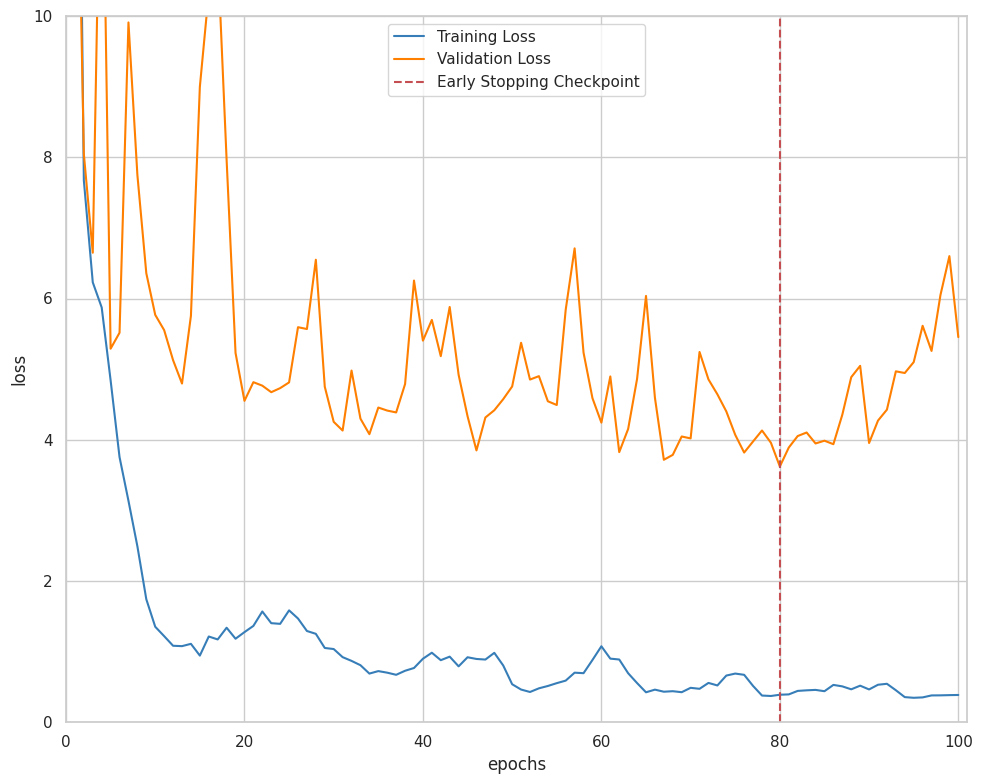

In [75]:
# visualize the loss as the network trained
fig = plt.figure(figsize=(10,8))
plt.plot(range(1,len(train_loss)+1),train_loss, label='Training Loss', color="#377eb8")
plt.plot(range(1,len(valid_loss)+1),valid_loss,label='Validation Loss', color="#ff7f00")

# find position of lowest validation loss
minposs = valid_loss.index(min(valid_loss))+1
plt.axvline(minposs, linestyle='--', color='r',label='Early Stopping Checkpoint')

plt.xlabel('epochs')
plt.ylabel('loss')
plt.ylim(0, 10.0) # consistent scale
plt.xlim(0, len(train_loss)+1) # consistent scale
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
fig.savefig('loss_plot.png', bbox_inches='tight')

#**Evaluation using testset**

In [76]:
#evaluation using validation dataset
val_dataset = Create_Datasets(val_set[0], CSV_PATH, val_data_transforms)
val_loader = DataLoader(val_dataset, batch_size = 1)

def my_round(x, d=0):
    p = 10 ** d
    return float(math.floor((x * p) + math.copysign(0.5, x)))/p


model_ft.eval() # prep model for evaluation

outputs,targets,errors =[], [], []
for image_tensor, target in val_loader:
      target = target.view(len(target), 1)
      image_tensor = image_tensor.to(device)
      target = target.to(device)
      # forward pass: compute predicted outputs by passing inputs to the model
      output = model_ft(image_tensor)


      outputs.append(output[0].item())
      targets.append(target[0].item())
      #print('estimate R:'+str(my_round(output[0,0].item()))+'mm, L:'+str(my_round(output[0,1].item()))+'mm / target R:'+str(target[0,0].item())+'mm, L:'+str(target[0,1].item())+'mm')

      errors.append(output[0].item()-target[0].item())

AbsError = [abs(i) for i in errors]

print('AveError: '+str(statistics.mean(errors)))
print('StdError: '+str(statistics.stdev(errors)))
print('AveAbsError: '+str(statistics.mean(AbsError)))
print('StdAbsError: '+str(statistics.stdev(AbsError)))
print('')


#平均からの差分を補正
corrected_output = (np.array(outputs)-np.array(statistics.mean(errors))).tolist()
corrected_error = (np.array(corrected_output)-np.array(targets)).tolist()
corrected_AbsError = [abs(i) for i in corrected_error]

round_output = [my_round(i) for i in outputs]
round_corrected_AbsError = [my_round(i) for i in corrected_AbsError]

print('Corrected_AveAbsError: '+str(statistics.mean(corrected_AbsError)))
print('Corrected_StdAbsError: '+str(statistics.stdev(corrected_AbsError)))
print('Round_Corrected_AveAbsError: '+str(statistics.mean(round_corrected_AbsError)))
print('Round_Corrected_StdAbsError: '+str(statistics.stdev(round_corrected_AbsError)))

# Calculate the probabilities
abs_error_np = np.array(AbsError)
prob_less_than_1 = np.sum(abs_error_np <= 1) / len(AbsError)
prob_less_than_2 = np.sum(abs_error_np <= 2) / len(AbsError)

print('Probability of AbsError <= 1:', prob_less_than_1)
print('Probability of AbsError <= 2:', prob_less_than_2)

AveError: 0.0664682442646081
StdError: 1.9045242943672378
AveAbsError: 1.4934253285073826
StdAbsError: 1.181080812575389

Corrected_AveAbsError: 1.4889594072405439
Corrected_StdAbsError: 1.1848537400785073
Round_Corrected_AveAbsError: 1.4672364672364673
Round_Corrected_StdAbsError: 1.2275099294020504
Probability of AbsError <= 1: 0.4301994301994302
Probability of AbsError <= 2: 0.7236467236467237


In [77]:
#evaluation using test dataset

def my_round(x, d=0):
    p = 10 ** d
    return float(math.floor((x * p) + math.copysign(0.5, x)))/p



model_ft.eval() # prep model for evaluation

outputs,targets,errors =[], [], []
for image_tensor, target in test_loader:
      target = target.view(len(target), 1)
      image_tensor = image_tensor.to(device)
      target = target.to(device)
      # forward pass: compute predicted outputs by passing inputs to the model
      output = model_ft(image_tensor)


      outputs.append(output[0].item())
      targets.append(target[0].item())
      #print('estimate R:'+str(my_round(output[0,0].item()))+'mm, L:'+str(my_round(output[0,1].item()))+'mm / target R:'+str(target[0,0].item())+'mm, L:'+str(target[0,1].item())+'mm')

      errors.append(output[0].item()-target[0].item())

AbsError = [abs(i) for i in errors]

print('AveError: '+str(statistics.mean(errors)))
print('StdError: '+str(statistics.stdev(errors)))
print('AveAbsError: '+str(statistics.mean(AbsError)))
print('StdAbsError: '+str(statistics.stdev(AbsError)))
print('')


#平均からの差分を補正
corrected_output = (np.array(outputs)-np.array(statistics.mean(errors))).tolist()
corrected_error = (np.array(corrected_output)-np.array(targets)).tolist()
corrected_AbsError = [abs(i) for i in corrected_error]

round_output = [my_round(i) for i in outputs]
round_corrected_AbsError = [my_round(i) for i in corrected_AbsError]

print('Corrected_AveError: '+str(statistics.mean(corrected_error))) #平均誤差
print('Corrected_StdError: '+str(statistics.stdev(corrected_error))) #誤差標準偏差
print('Corrected_AveAbsError: '+str(statistics.mean(corrected_AbsError))) #平均絶対誤差
print('Corrected_StdAbsError: '+str(statistics.stdev(corrected_AbsError))) #絶対誤差標準偏差
print('Round_Corrected_AveAbsError: '+str(statistics.mean(round_corrected_AbsError))) #平均絶対誤差(四捨五入)
print('Round_Corrected_StdAbsError: '+str(statistics.stdev(round_corrected_AbsError))) #絶対誤差標準偏差(四捨五入)
print('')


# Calculate the probabilities
abs_error_np = np.array(AbsError)
prob_less_than_1 = np.sum(abs_error_np <= 1) / len(AbsError)
prob_less_than_2 = np.sum(abs_error_np <= 2) / len(AbsError)

print('Probability of AbsError <= 1:', prob_less_than_1)
print('Probability of AbsError <= 2:', prob_less_than_2)


AveError: 0.2695721940895946
StdError: 2.0043178747686596
AveAbsError: 1.6370583121309574
StdAbsError: 1.1817318287714869

Corrected_AveError: 2.5638139950106705e-16
Corrected_StdError: 2.0043178747686596
Corrected_AveAbsError: 1.6161079593743182
Corrected_StdAbsError: 1.179810382519211
Round_Corrected_AveAbsError: 1.6185567010309279
Round_Corrected_StdAbsError: 1.250436599143747

Probability of AbsError <= 1: 0.3865979381443299
Probability of AbsError <= 2: 0.7061855670103093


In [1]:
#Draw Graphs（もともとの散布図
df = pd.DataFrame({'estimate':outputs, 'target':targets})

sns.set_style('whitegrid')
sns.set_palette('gray')
sns.lmplot(x='estimate', y='target', data=df)
plt.xlim(10,24)
plt.ylim(10,24)

NameError: ignored

In [ ]:
#Bland-Altman-Plot

def bland_altman_plot(data1, data2, *args, **kwargs):
    data1     = np.asarray(data1)
    data2     = np.asarray(data2)
    mean      = np.mean([data1, data2], axis=0)
    diff      = data1 - data2                   # Difference between data1 and data2
    md        = np.mean(diff)                   # Mean of the difference
    sd        = np.std(diff, axis=0)            # Standard deviation of the difference
    plt.scatter(mean, diff, *args, **kwargs)
    plt.axhline(md,           color='gray', linestyle='--')
    plt.axhline(md + 1.96*sd, color='gray', linestyle='--')
    plt.axhline(md - 1.96*sd, color='gray', linestyle='--')

bland_altman_plot(outputs, targets)
plt.title('Bland-Altman Plot')
plt.show()

In [ ]:
#線形近似式算出
from sklearn import linear_model

estimate = df.loc[:,'estimate']
target = df.loc[:,'target']
clf = linear_model.LinearRegression()

# 説明変数xに "x1"のデータを使用
x = np.array([estimate]).T

# 目的変数yに "x2"のデータを使用
y = target.values

# 予測モデルを作成（単回帰）
clf.fit(x, y)

# パラメータ（回帰係数、切片）を抽出
[a] = clf.coef_
b = clf.intercept_

# パラメータの表示
print("回帰係数:", a)
print("切片:", b)
print("決定係数:", clf.score(x, y))

#平均値により補正した値
df['Corrected_estimate_1']=0
for i in range(len(df)):
    df.iloc[i,2] = corrected_output[i]

#回帰直線により補正した値
df['Corrected_estimate_2']=0
for i in range(len(df)):
    df.iloc[i,3] = df.iloc[i,0]*a+b

#残差
df['Residual_error_1']=0
for i in range(len(df)):
    df.iloc[i,4] = df.iloc[i,2]-df.iloc[i,1]

#残差
df['Residual_error_2']=0
for i in range(len(df)):
    df.iloc[i,5] = df.iloc[i,3]-df.iloc[i,1]

In [ ]:
df.head()

In [ ]:
#平均近似バージョン
#Draw histogram
sns.distplot(
    df['Residual_error_1'], bins=13, color='#123456', label='residual_error',
    kde=False,
    rug=False
)
plt.legend() # 凡例を表示
plt.show()   # ヒストグラムを表示


#Draw Graphs
sns.set_style('whitegrid')
sns.set_palette('gray')
sns.lmplot(x='Corrected_estimate_1', y='target', data=df)
plt.xlim(10,24)
plt.ylim(10,24)

corrected_AbsError = [abs(i) for i in df['Residual_error_1']]
print('AveError: '+str(statistics.mean(df['Residual_error_1'])))
print('StdError: '+str(statistics.stdev(df['Residual_error_1'])))
print('AveAbsError: '+str(statistics.mean(corrected_AbsError)))
print('StdAbsError: '+str(statistics.stdev(corrected_AbsError)))

round_output = [my_round(i) for i in outputs]
round_corrected_AbsError = [my_round(i) for i in corrected_AbsError]
print('Round_Corrected_AveAbsError: '+str(statistics.mean(round_corrected_AbsError)))
print('Round_Corrected_StdAbsError: '+str(statistics.stdev(round_corrected_AbsError)))


# print("")
# print('Error<-1 and Error>-1: ' + str(sum((-1 < i < 1 for i in df['Residual_error_2']))))
# print('Error<-2 and Error>2: ' + str(sum((-2 < i < 2 for i in df['Residual_error_2']))))
# print('Error<=-2: ' +  str(sum((i <= -2 for i in df['Residual_error_2']))))
# print('Error>=2: ' +  str(sum((i >= 2 for i in df['Residual_error_2']))))

total_errors = len(df['Residual_error_2'])

error_minus1_to_1_count = sum((-1 < i < 1 for i in df['Residual_error_2']))
error_minus1_to_1_percentage = (error_minus1_to_1_count / total_errors) * 100

error_minus2_to_2_count = sum((-2 < i < 2 for i in df['Residual_error_2']))
error_minus2_to_2_percentage = (error_minus2_to_2_count / total_errors) * 100

error_less_equal_minus2_count = sum((i <= -2 for i in df['Residual_error_2']))
error_less_equal_minus2_percentage = (error_less_equal_minus2_count / total_errors) * 100

error_greater_equal_2_count = sum((i >= 2 for i in df['Residual_error_2']))
error_greater_equal_2_percentage = (error_greater_equal_2_count / total_errors) * 100

print("")
print(f'Error<-1 and Error>-1: {error_minus1_to_1_count}/{total_errors} ({error_minus1_to_1_percentage:.2f}%)')
print(f'Error<-2 and Error>2: {error_minus2_to_2_count}/{total_errors} ({error_minus2_to_2_percentage:.2f}%)')
print(f'Error<=-2: {error_less_equal_minus2_count}/{total_errors} ({error_less_equal_minus2_percentage:.2f}%)')
print(f'Error>=2: {error_greater_equal_2_count}/{total_errors} ({error_greater_equal_2_percentage:.2f}%)')





TP, FP, TN, FN = 0,0,0,0
for i in range(len(df)):
    if df.iloc[i,1]>=18 and df.iloc[i,2]>= 18:
        TP += 1
    if df.iloc[i,1]<18 and df.iloc[i,2]>= 18:
        FP += 1
    if df.iloc[i,1]>=18 and df.iloc[i,2]< 18:
        FN += 1
    if df.iloc[i,1]<18 and df.iloc[i,2]< 18:
        TN += 1

print('')
print('Hertel 18mm以上の検出精度')
print('TP: '+str(TP))
print('FP: '+str(FP))
print('FN: '+str(FN))
print('TN: '+str(TN))
print('Sensitivity: '+str(TP/(TP+FN)))
print('Specificity: '+str(TN/(FP+TN)))
print('Positive predictive value: '+str(TP/(TP+FP)))
print('Negative predictive value: '+str(TN/(TN+FN)))


okpositive, minogashi, oknegative, kajyou = 0,0,0,0
for i in range(len(df)):
    if df.iloc[i,1]>=16 and df.iloc[i,2]> 18:
        okpositive += 1
    if df.iloc[i,1]<16 and df.iloc[i,2]>= 18:
        kajyou += 1
    if df.iloc[i,1]>=18 and df.iloc[i,2]<= 16:
        minogashi += 1
    if df.iloc[i,1]<18 and df.iloc[i,2]<= 16:
        oknegative += 1

print('')
print('推測18mm以上だが実は16mm未満(過剰): '+str(kajyou)+'例')
print('推測16mm未満だが実は18mm以上（見逃がし）: '+str(minogashi)+'例')

#**Export coreML including non-max supression**

In [ ]:
# clone Yolov5 repo
import os
%cd /content
!git clone https://github.com/ultralytics/yolov5.git
%cd yolov5
!pip install -r requirements.txt -r requirements.txt

In [ ]:
weight_path = "/content/drive/MyDrive/Deep_learning/GO_extended_dataset/super_extend_for_YOLO_training/yolov5n-iFish_120epoch.pt"

In [ ]:
#!python export.py --weights /content/drive/MyDrive/Deep_learning/GO_extended_dataset/super_extend_for_YOLO_training/yolov5n-iFish_120epoch.pt --nms --include coreml
!python export.py --weights $weight_path --nms --include "coreml"


In [ ]:
# clone Yolov5 repo
import os
%cd /content
!git clone https://github.com/hietalajulius/yolov5.git
%cd yolov5
!pip install -r requirements.txt -r requirements-export.txt

In [ ]:
weight_path = "/content/drive/MyDrive/Deep_learning/GO_extended_dataset/periocular_for_YOLO_training/yolo5n_100epoch.pt"

In [ ]:
!python export-nms.py --include coreml --weights $weight_path


#**Interference and crop Extended dataset**

In [ ]:
# Setup YOLOv5
%cd /content/drive/MyDrive/Deep_learning/GO_extended_dataset/periocular_for_YOLO_training
!git clone https://github.com/ultralytics/yolov5
%cd yolov5
%pip install -qr requirements.txt

import torch
import utils
display = utils.notebook_init()

YOLOv5 🚀 v7.0-72-g064365d Python-3.8.10 torch-1.13.1+cu116 CUDA:0 (NVIDIA A100-SXM4-40GB, 40536MiB)


Setup complete ✅ (12 CPUs, 83.5 GB RAM, 24.9/166.8 GB disk)


In [ ]:
# パスを指定する
weight = "/content/drive/MyDrive/Deep_learning/GO_extended_dataset/periocular_for_YOLO_training/yolo5n_100epoch.pt"
input_folder = "/content/drive/MyDrive/Deep_learning/GO_extended_dataset/periocular_for_YOLO_training/train/images"
output_folder = "/content/drive/MyDrive/Deep_learning/GO_extended_dataset/periocular_cropped_using_YOLO/train"

In [ ]:
from models.common import DetectMultiBackend
#from utils.datasets import IMG_FORMATS, VID_FORMATS, LoadImages, LoadStreams
from utils.general import (LOGGER, check_file, check_img_size, check_imshow, check_requirements, colorstr,
                           increment_path, non_max_suppression, print_args, strip_optimizer, xyxy2xywh)
#from utils.plots import Annotator, colors, save_one_box
from utils.torch_utils import select_device, time_sync
from utils.augmentations import letterbox #padding

from PIL import Image
import torch
from torchvision import models, transforms
import cv2
import numpy as np

#サポートパッチのインポート
from google.colab.patches import cv2_imshow


def interference(img, weight):
    #stride, names, pt, jit, onnx, engine = model.stride, model.names, model.pt, model.jit, model.onnx, model.engine
    #imgsz = check_img_size([640], s=stride)  # check image size

    #class_names = {0:"cont", 1:"grav"}

    # transform = transforms.Compose([
    #             transforms.Resize(size=(480,640)),
    #             transforms.ToTensor(),
    #             # transforms.Normalize(
    #             #     mean=[0.5, 0.5, 0.5],
    #             #     std=[0.5, 0.5, 0.5]
    #             #    )
    #             ])

    img_cv2 = cv2.imread(img) #CV2で開く
    img_cv2 = letterbox(img_cv2, (640,640), stride=32, auto=False)[0] #resize, 上下padding (color 114)

    #cv2_imshow(img_cv2)

    img_cv2 = img_cv2.transpose((2, 0, 1))[::-1]  # HWC to CHW, BGR to RGB
    img_cv2 = np.ascontiguousarray(img_cv2)
    img_tensor = torch.from_numpy(img_cv2).float()

    #img_tensor = transform(img_np)
    img_tensor /= 255
    #print(img_tensor.shape)

    #print(img_tensor)
    img_tensor = torch.unsqueeze(img_tensor, 0)  # バッチ対応


    pred = model(img_tensor, visualize=False, augment=False)

    pred = non_max_suppression(pred, conf_thres=0.25, iou_thres=0.45, classes=None,  max_det=1000)

    print(f"pred: {pred}")

    return pred

In [ ]:
from tqdm import tqdm
import os

# image_path = glob.glob(f"{dataset_grav}/*")
# img = image_path[100]

class_names = {0:"cont", 1:"grav"}

device = 'cpu' # device = None or 'cpu' or 0 or '0' or '0,1,2,3'
device = select_device(device)
model = DetectMultiBackend(weight, device=device, dnn=False)

os.makedirs(output_folder, exist_ok=True)

for img in tqdm(glob.glob(f"{input_folder}/*")):

    pred = interference(img, weight)

    # output result
    x1, y1, x2, y2, prob, class_num = torch.round(pred[0][0])

    # probability
    prob = pred[0][0][4].item()

    # class
    class_name = class_names[pred[0][0][5].item()]

    print("診断は %s、確率は%.1f％です。" %(class_name, prob*100))

    img_cv2 = cv2.imread(img)

    # calculate coordinates of the bounding box (640*640にpaddingされている分の座標を足す)
    img_height, img_width, _ = img_cv2.shape[:3]
    print(f"img_height: {img_height}, img_width: {img_width}")
    padding_x = (img_height - min(img_width, img_height))/2
    padding_y = (img_width - min(img_width, img_height))/2
    x1 = x1 - padding_x
    y1 = y1 - padding_y
    x2 = x2 - padding_x
    y2 = y2 - padding_y
    print(f"x1: {x1}, y1: {y1}, x2: {x2}, y2: {y2}")

    # draw bounding box
    #cv2.rectangle(img_cv2, (int(x1), int(y1)), (int(x2), int(y2)), (255, 0, 0), 2)

    # show image
    #cv2_imshow(img_cv2)

    # バウンディングボックスで画像を切り抜く」

    if x1 < 0: #負の場合のエラー回避
        x1 = 0

    cropped_image = img_cv2[int(y1):int(y2), int(x1):int(x2)]

    # 切り抜いた画像を保存する
    save_path = f"{output_folder}/{os.path.basename(img)}"
    print(save_path)
    #cv2_imshow(cropped_image)
    cv2.imwrite(save_path, cropped_image)

In [ ]:
#rewrite csv file (bootcamp用csvのimage_pathを改変)
import pandas as pd

csv_1_orig = "/content/drive/MyDrive/Deep_learning/GO_extended_dataset/periocular_for_YOLO_training/train_list.csv"
csv_2_orig = "/content/drive/MyDrive/Deep_learning/GO_extended_dataset/periocular_for_YOLO_training/valid_list.csv"
csv_1 = "/content/drive/MyDrive/Deep_learning/GO_extended_dataset/periocular_cropped_using_YOLO/train_list.csv"
csv_2 = "/content/drive/MyDrive/Deep_learning/GO_extended_dataset/periocular_cropped_using_YOLO/valid_list.csv"

def rewrite_csv(df):
    path_list = []
    for path in df["image_path"]:
        path = path.replace("periocular_for_YOLO_training", "periocular_cropped_using_YOLO")
        path = path.replace("images/", "")
        path_list.append(path)
    df["image_path"] = path_list
    return(df)

df = pd.read_csv(csv_1_orig)
df = rewrite_csv(df)
print(df)
df.to_csv(csv_1, index=False)

df = pd.read_csv(csv_2_orig)
df = rewrite_csv(df)
df.to_csv(csv_2,  index=False)

#**YOLOv5-EigenCAM**

https://jacobgil.github.io/pytorch-gradcam-book/EigenCAM%20for%20YOLO5.html

In [ ]:
%cd /content
!git clone https://github.com/jacobgil/pytorch-grad-cam.git

/content
Cloning into 'pytorch-grad-cam'...
remote: Enumerating objects: 1122, done.
remote: Counting objects: 100% (25/25), done.
remote: Compressing objects: 100% (22/22), done.
remote: Total 1122 (delta 8), reused 9 (delta 3), pack-reused 1097
Receiving objects: 100% (1122/1122), 110.21 MiB | 15.74 MiB/s, done.
Resolving deltas: 100% (617/617), done.


In [ ]:
%cd /content/pytorch-grad-cam

/content/pytorch-grad-cam


In [ ]:
!pip install pytorch-gradcam

In [ ]:
!pip install ttach

In [ ]:
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')
import torch
import cv2
import numpy as np
import requests
import torchvision.transforms as transforms
from pytorch_grad_cam import EigenCAM
from pytorch_grad_cam.utils.image import show_cam_on_image, scale_cam_image
from PIL import Image

COLORS = np.random.uniform(0, 255, size=(80, 3))

def parse_detections(results):
    detections = results.pandas().xyxy[0]
    detections = detections.to_dict()
    boxes, colors, names = [], [], []

    for i in range(len(detections["xmin"])):
        confidence = detections["confidence"][i]
        if confidence < 0.2:
            continue
        xmin = int(detections["xmin"][i])
        ymin = int(detections["ymin"][i])
        xmax = int(detections["xmax"][i])
        ymax = int(detections["ymax"][i])
        name = detections["name"][i]
        category = int(detections["class"][i])
        color = COLORS[category]

        boxes.append((xmin, ymin, xmax, ymax))
        colors.append(color)
        names.append(name)
    return boxes, colors, names


def draw_detections(boxes, colors, names, img):
    for box, color, name in zip(boxes, colors, names):
        xmin, ymin, xmax, ymax = box
        cv2.rectangle(
            img,
            (xmin, ymin),
            (xmax, ymax),
            color,
            2)

        cv2.putText(img, name, (xmin, ymin - 5),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.8, color, 2,
                    lineType=cv2.LINE_AA)
    return img


image_url = "https://www.thesprucepets.com/thmb/3ABKoAPm0Hu4PcWsDH1giawq7ck=/750x0/filters:no_upscale():max_bytes(150000):strip_icc():format(webp)/chinese-dog-breeds-4797219-hero-2a1e9c5ed2c54d00aef75b05c5db399c.jpg"
img = np.array(Image.open(requests.get(image_url, stream=True).raw))
img = cv2.resize(img, (640, 640))
rgb_img = img.copy()
img = np.float32(img) / 255
transform = transforms.ToTensor()
tensor = transform(img).unsqueeze(0)

model = torch.hub.load('ultralytics/yolov5', 'yolov5s', pretrained=True)
model.eval()
model.cpu()
target_layers = [model.model.model.model[-2]]

results = model([rgb_img])
boxes, colors, names = parse_detections(results)
detections = draw_detections(boxes, colors, names, rgb_img.copy())
Image.fromarray(detections)

# **To do Next**

・外部のデータセット（Treated）を洗い出し

・内部のデータセットをさらに水増し

・内部および外部データセットより、test用各100枚（grav50枚、cont50枚）を抜き出しておき、合体する

・既存のYOLOv5を用いてbounding boxを抜き出し、新たにトレーニングする